<a href="https://cognitiveclass.ai"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0101EN-SkillsNetwork/images/IDSN-logo.png" width="400"> </a>

# Transformers with Keras

Estimated time needed **45** mins


In this lab, we will learn how to use the Keras library to build a transformer using a sequence-to-sequence architecture with self-attention for translation. We will train the model using a sample dataset and then use this model for English to Spanish translation.


# Objectives for this Notebook    
* How to use the Keras library to build transformers model
* Train the transformer model using a given dataset
* Use the trained transformer model to translate


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 4>
1. <a href="#Import-Keras-and-Packages">Import Keras and Packages</a><br>
2. <a href="#Step-1:-Data-Preparation">Step 1: Data Preparation</a><br>
3. <a href="#Step-2:-Self-Attention-Layer">Step 2: Self-Attention Layer</a><br>
4. <a href="#Step-3:-Model-Architecture">Step 3: Model Architecture</a><br>
5. <a href="#Step-4:-Training-the-Model">Step 4: Training the Model</a><br>
6. <a href="#Step-5:-Plotting-the-training-loss">Step 5: Plotting the training loss</a><br>

</font>
</div>


## Import Keras and Packages


Let's start by importing the keras libraries and the packages that we would need to build a neural network.


The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:


In [1]:
!pip install tensorflow==2.17.1
!pip install matplotlib==3.9.2

print("==== All required libraries are installed =====")

  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ---------------------------------------- 0.0/382.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/382.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/382.4 MB 1.9 MB/s eta 0:03:26
   ---------------------------------------- 1.0/382.4 MB 1.7 MB/s eta 0:03:41
   ---------------------------------------- 1.3/382.4 MB 1.6 MB/s eta 0:03:53
   ---------------------------------------- 1.8/382.4 MB 1.8 MB/s eta 0:03:36
   ---------------------------------------- 2.1/382.4 MB 1.7 MB/s eta 0:03:44
   ---------------------------------------- 2.1/382.4 MB 1.7 MB/s eta 0:03:44
   ---------------------------------------- 2.1/382.4 MB 1.7 MB/s eta 0:03:44
   ---------------------------------------- 2.1/382.4 MB 1.7 MB/s eta 0:03:44
   ---------------------------------------- 2.4/382.4 MB 1.1 MB/s eta 0:06:00
   ---------------------------------------- 2.9/382.4 MB 1.2 MB/s eta 0:05:17
   ----------

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


==== All required libraries are installed =====


#### Suppress the tensorflow warning messages
We use the following code to  suppress the warning messages due to use of CPU architechture for tensoflow.

You may want to **comment out** these lines if you are using the GPU architechture


In [13]:
# import os
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

##### To use Keras, you will also need to install a backend framework – such as TensorFlow.

If you install TensorFlow 2.16 or above, it will install Keras by default.

We are using the CPU version of tensorflow since we are dealing with smaller datasets. 
You may install the GPU version of tensorflow on your machine to accelarate the processing of larger datasets


### Import the necessary libraries


In [14]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from keras.layers import Layer
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Step 1: Data Preparation
We start by define the sentences and text for translation training
Sentence Pairs: Defines a small dataset of English-Spanish sentence pairs.
Target Sequences:
Prepends "startseq" and appends "endseq" to each target sentence for the decoder to learn when to start and stop translating.


In [15]:
# Sample parallel sentences (English -> Spanish)
input_texts = [
    "Hello.", "How are you?", "I am learning machine translation.", "What is your name?", "I love programming."
]
target_texts = [
    "Hola.", "¿Cómo estás?", "Estoy aprendiendo traducción automática.", "¿Cuál es tu nombre?", "Me encanta programar."
]

target_texts = ["startseq " + x + " endseq" for x in target_texts]

## Next, we convert the text from the sentences to tokens and create a vocabulary
Tokenization: Uses Tokenizer to convert words into numerical sequences.


In [16]:
# Tokenization
input_tokenizer = Tokenizer()
# print(input_tokenizer)
input_tokenizer.fit_on_texts(input_texts)

input_sequences = input_tokenizer.texts_to_sequences(input_texts)
print(input_sequences)
output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_texts)
output_sequences = output_tokenizer.texts_to_sequences(target_texts)
print(output_sequences)
input_vocab_size = len(input_tokenizer.word_index) + 14
output_vocab_size = len(output_tokenizer.word_index) + 1

[[2], [3, 4, 5], [1, 6, 7, 8, 9], [10, 11, 12, 13], [1, 14, 15]]
[[1, 3, 2], [1, 4, 5, 2], [1, 6, 7, 8, 9, 2], [1, 10, 11, 12, 13, 2], [1, 14, 15, 16, 2]]


### Now pad the corresponding sentences
Padding: Ensures all sequences have the same length.


In [17]:
# Padding
max_input_length = max([len(seq) for seq in input_sequences])
max_output_length = max([len(seq) for seq in output_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

In [18]:
# Prepare the target data for training
decoder_input_data = output_sequences[:, :-1]
decoder_output_data = output_sequences[:, 1:]

# Convert to one-hot
decoder_output_data = np.array([np.eye(output_vocab_size)[seq] for seq in decoder_output_data])

# Step 2: Self-Attention Layer
Self-attention is a mechanism that allows a model to **focus on relevant parts of the input sequence** while processing each word. This is particularly useful in:
1) Machine Translation (e.g., aligning words correctly)
2) Text Summarization
3) Speech Recognition
4) Image Processing (Vision Transformers)
In this implementation, self-attention is used for text based sequence-to-sequence modeling.


Self-Attention works for a given an input sequence by computing a weighted representation of all words for each position. It does so using three key components:

1. Query **(Q)**, Key **(K)**, and Value **(V)** Matrices
For each word (token) in a sequence:

Query (Q): What this word is looking for.
Key (K): What this word represents.
Value (V): The actual information in the word.

2. Compute **Attention Scores**
Next, we **calculate the similarity between each query and key** using dot-product attention:
Each word in a sequence attends to every other word based on these scores.

3. Apply **Scaling & Softmax**
Since dot-product values can be large, we scale them. 
Next, Applying softmax converts scores into attention weights:


### Self-Attention class
In this implementation of self-attention layer:
1. We first initialize the weights in the **build** method, where:
    1. **self.Wq**, **self.Wk**, **self.Wv** are the trainable weight matrices.
    2. Their **shape is (feature_dim, feature_dim)**, meaning they transform input features into Q, K, and V representations.
2. Applying Attention using **call** method. The **call()** method:
   1. Computes **Q, K, V** by multiplying inputs (encoder/decoder output) with their respective weight matrices.
   2. Computes **dot-product attention scores** using K.batch_dot(q, k, axes=[2, 2]), resulting in a (batch_size, seq_len, seq_len) matrix.
   3. **Scales** the scores to avoid large values.
   4. Applies **softmax** to normalize the attention scores.
   5. **Multiplies attention weights with V** to get the final output.
3. The **compute_output_shape** method defines the shape of the output tensor after the layer processes an input.
    1. The output shape of the Self-Attention layer **remains the same** as the input shape.
    2. The attention mechanism **transforms** the input but does not change its dimensions.4
    3. If the attention layer changed the shape, you would modify compute_output_shape


In [19]:
# Define the Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Weight matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='glorot_uniform', 
                                  trainable=True, 
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='glorot_uniform', 
                                  trainable=True, 
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='glorot_uniform', 
                                  trainable=True, 
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linear projections
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

# Step 3: Model Architecture
The model follows an Encoder-Decoder structure:

### Encoder:
1) Takes input sentences (padded and tokenized).
2) Uses an Embedding layer (word representations) + LSTM (to process sequences).
    1. The LSTMs are used as the **help process variable-length input sentences** and generate meaningful translations.
4) Outputs context vectors (hidden & cell states).

### Attention Layer
1) Applied to both the encoder and decoder outputs.
2) Helps the decoder focus on relevant words during translation.

### Decoder
1) Receives target sequences (shifted one step ahead).
2) Uses an LSTM with encoder states as initial states.
3) Applies self-attention for better learning.
4) Uses a Dense layer (Softmax) to predict the next word.


In [20]:
from tensorflow.keras.layers import AdditiveAttention, Concatenate, Dense, Embedding, Input, LSTM
from tensorflow.keras.models import Model
 
# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]
 
# Decoder
decoder_inputs = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
 
# Attention: decoder attends to encoder outputs
attention = AdditiveAttention()
attention_output = attention([decoder_outputs, encoder_outputs])
 
# Combine decoder outputs with attention context
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_output])
 
# Final Dense layer
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)
 
# Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
# Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 5, 256)    │      7,424 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 5, 256)    │      4,352 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 5, 256),  │    525,312 │ embedding_2[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 5, 256),  │    525,312 │ embedding_3[0][0… │
│                     │ (None, 256),      │            │ lstm_2[0][1],     │
│                     │ (None, 256)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, 5, 256)    │        256 │ lstm_3[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 5, 512)    │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5, 17)     │      8,721 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,071,377 (4.09 MB)

 Trainable params: 1,071,377 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

# Step 4: Training the Model
Uses categorical_crossentropy as the loss function since output words are one-hot encoded.
Trains using Adam optimizer for 100 epochs.


In [21]:
# Step 6: Train the Model
history_glorot_adam = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=300, batch_size=16)

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0400 - loss: 2.8364
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3600 - loss: 2.8063
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3600 - loss: 2.7751
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3200 - loss: 2.7402
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3200 - loss: 2.6985
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3200 - loss: 2.6463
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3200 - loss: 2.5788
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3200 - loss: 2.4899
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2800 - loss: 2.3746
Epoch 10/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2800 - loss: 2.2364
Epoch 11/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2800 - loss: 2.1064
Epoch 12/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2800 - loss

# Step 5: Plotting the training loss


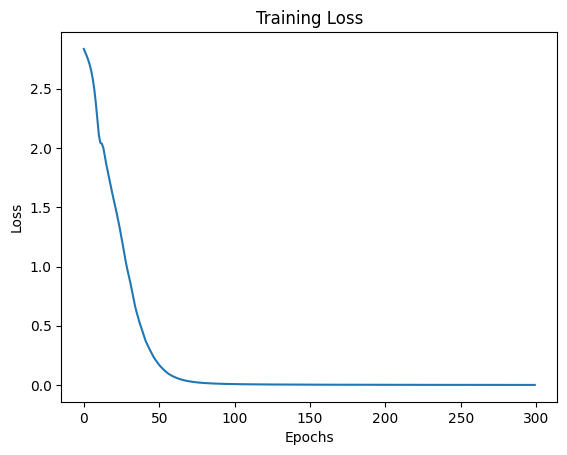

In [22]:
# Plotting training loss
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Awesome, now you have succesfully trained a transformers model.
### Now let's try some practice excercises


## Practice excercise 1


In this practice exercise, let's train the model using "he_uniform" initializer instead of "glorot_uniform". Then, compare the training loss between model using "glorot_uniform" vs "he_uniform" initializers by plotting them using matplotlib


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0400 - loss: 2.8364
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2400 - loss: 2.8047
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2400 - loss: 2.7715
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2400 - loss: 2.7336
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2400 - loss: 2.6874
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2400 - loss: 2.6284
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2400 - loss: 2.5508
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2400 - loss: 2.4485
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2400 - loss: 2.3196
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2400 - loss: 2.1848
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2400 - loss: 2.1062
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2400 - loss

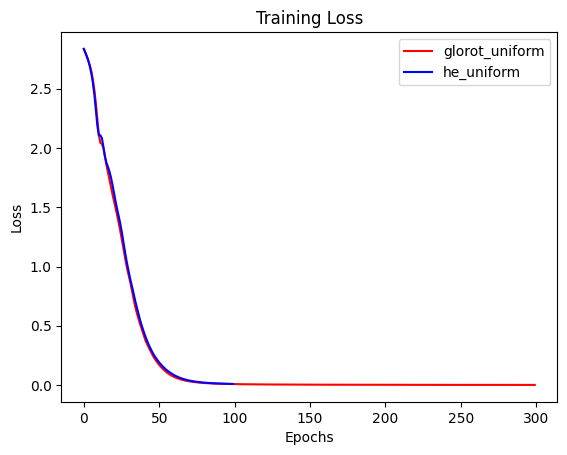

In [23]:
## Write your answer here
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Weight matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linear projections
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

    
#Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

#Decoder
decoder_inputs = Input(shape=(max_output_length - 1,), name="decoder_inputs")
decoder_embedding = Embedding(output_vocab_size, 256, name="decoder_embedding")(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

#Attention Mechanism
attention = AdditiveAttention(name="attention_layer")
attention_output = attention([decoder_outputs, encoder_outputs])

# Concatenate context with decoder outputs
decoder_concat = Concatenate(axis=-1, name="concat_layer")([decoder_outputs, attention_output])

# Final Dense Layer
decoder_dense = Dense(output_vocab_size, activation='softmax', name="output_dense")
decoder_outputs = decoder_dense(decoder_concat)

#Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#Step 6: Train the Model
history_he = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

#Plotting training losses for glorot_uniform and he_uniform inititalizers
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="glorot_uniform", color='red')
plt.plot(history_he.history['loss'], label="he_uniform", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Double-click <b>here</b> for the solution.

<!-- Your answer is below:


#Define the Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Weight matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linear projections
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

    
#Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

#Decoder
decoder_inputs = Input(shape=(max_output_length - 1,), name="decoder_inputs")
decoder_embedding = Embedding(output_vocab_size, 256, name="decoder_embedding")(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

#Attention Mechanism
attention = AdditiveAttention(name="attention_layer")
attention_output = attention([decoder_outputs, encoder_outputs])

# Concatenate context with decoder outputs
decoder_concat = Concatenate(axis=-1, name="concat_layer")([decoder_outputs, attention_output])

# Final Dense Layer
decoder_dense = Dense(output_vocab_size, activation='softmax', name="output_dense")
decoder_outputs = decoder_dense(decoder_concat)

#Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#Step 6: Train the Model
history_he = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

#Plotting training losses for glorot_uniform and he_uniform inititalizers
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="glorot_uniform", color='red')
plt.plot(history_he.history['loss'], label="he_uniform", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


-->


## Practice excercise 2


In this practice exercise, try to use adaptive gradient optimizer instead of adam. Then, plot and compare the results between adam and adaptive gradient optimizers


In [ ]:
### Write your answer here



Double-click <b>here</b> for the solution.

<!-- Your answer is below:

#Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])


#Step 6: Train the Model
history_adagrad = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

#Plotting training losses for glorot_uniform and he_uniform inititalizers
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="adam", color='red')
plt.plot(history_adagrad.history['loss'], label="adagrad", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
-->


## Thank you for completing this lab!

This notebook was created by [Aman Aggarwal](https://www.linkedin.com/in/aggarwal-aman/). I hope you found this lab interesting and educational. Feel free to contact me if you have any questions!


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2024-11-20  | 1.0  | Aman  |  Created the lab |
<hr>
-->
## <h3 align="center"> © IBM Corporation. All rights reserved. <h3/>
